In this notebook, I followed the below blogpage until the implamentation of the mode: 

I had to add one additional dimension to the images for 'batch' that SegFormer model needs. That is why matplotlib functions will give an error (just skip for now). The ultimate error is for the last cell. This error occurs because the proj layer expects the input tensor to have a shape with the last dimension (axis -1) equal to 3, but the input shape received by the proj layer is (1, 134, 9, 128).

The issue seems to be related to the data preprocessing or input configuration for your model. To fix this, you should check the following:

Verify that the images in your dataset have the correct shape (height, width, channels). In this case, the channels should be 3, as it represents the RGB color channels.
Check the data preprocessing pipeline for your images. Ensure that the images are being loaded and resized correctly to the expected input shape of the model.
Verify the configuration of the proj layer or any other layer in your segformer model that might expect a specific input shape. Make sure the input shape is compatible with the model architecture.
Ensure that the input images are correctly passed to the model during training and validation.



https://www.analyticsvidhya.com/blog/2023/04/deep-learning-for-image-segmentation-with-tensorflow/

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
import os

# A list to collect paths of 1000 images
image_path = []
for root, dirs, files in os.walk('/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/xBD_test_subset_raw_reorganized/images'):
    # Iterate over 1000 images
    for file in files:
        # Check if the file has a PNG extension
        if file.lower().endswith('.png'):
            # Create path
            path = os.path.join(root, file)
            # Add path to list
            image_path.append(path)
print(len(image_path))

# A list to collect paths of 1000 masks
mask_path = []
for root, dirs, files in os.walk('/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/xBD_test_subset_raw_reorganized/masks'):
    # Iterate over 1000 masks
    for file in files:
        # Check if the file has a PNG extension
        if file.lower().endswith('.png'):
            # Obtain the path
            path = os.path.join(root, file)
            # Add path to the list
            mask_path.append(path)
print(len(mask_path))

     

110
110


In [5]:
# create a list to store images
images = []
# iterate over 1000 image paths
for path in tqdm(image_path):
    # read file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)

    #adding 4th dimension for batch size 
    image = tf.expand_dims(image, axis=0)
    # append to the list
    images.append(image)


# create a list to store masks
masks = []
# iterate over 1000 mask paths
for path in tqdm(mask_path):
    # read the file
    file = tf.io.read_file(path)
    # decode png file into a tensor
    mask = tf.image.decode_png(file, channels=3, dtype=tf.uint8)

    #adding 4th dimension for batch size 
    mask = tf.expand_dims(mask, axis=0)
    # append mask to the list
    masks.append(mask)

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:01<00:00, 89.28it/s]


In [6]:
# Print the shape of the first image
print(images[0].shape)

(1, 1024, 1024, 3)


TypeError: Invalid shape (1, 1024, 1024, 3) for image data

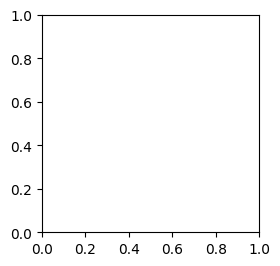

In [7]:
plt.figure(figsize=(25,13))

# Iterate over the images in the range 4-6
for i in range(4,7):
    # Create a subplot for each image
    plt.subplot(4,6,i)
    # Get the i-th image from the list
    img = images[i]
    # Show the image with a colorbar
    plt.imshow(img)
    plt.colorbar()
    # Turn off the axis labels
    plt.axis('off')

# Display the figure
plt.show()

TypeError: Invalid shape (1, 1024, 1024, 3) for image data

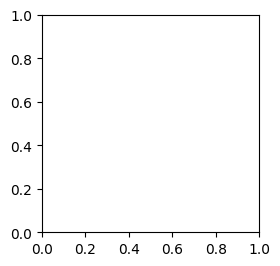

In [ ]:
# Define a normalizer that can be applied while visualizing masks to have a consistency
NORM = mpl.colors.Normalize(vmin=0, vmax=58)

# plot masks
plt.figure(figsize=(25,13))
for i in range(4,7):
    plt.subplot(4,6,i)
    img = masks[i]
    plt.imshow(img, cmap='jet', norm=NORM)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [ ]:
#functions to resize the images and masks 
def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask    
     

X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y) 

(110, 110)

TypeError: Invalid shape (1, 128, 128, 3) for image data

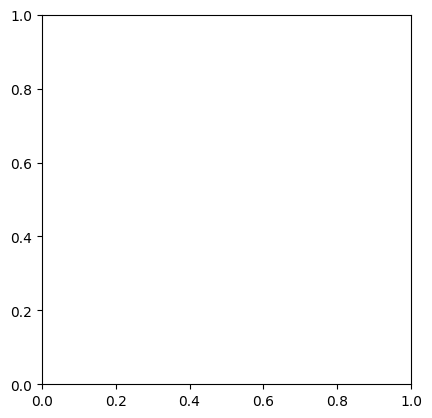

In [ ]:
#visualizing a resized image and respective mask
# plot an image
plt.imshow(X[36])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(y[36], cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )
# develop tf Dataset objects
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(1, 128, 128, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(1, 128, 128, 3), dtype=tf.uint8, name=None))

In [ ]:
# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# adjust gamma of image
# don't alter in mask
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

# adjust hue of image
# don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    mask = tf.cast(mask, tf.uint8)
    return img, mask
# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [ ]:
# zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

# concatenate every new augmented sets
train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)

In [ ]:
#setting the batch size
BATCH = 64

AT = tf.data.AUTOTUNE
#buffersize
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

From hereon, I added my code


In [ ]:
# load the model
# this part was take from: https://keras.io/examples/vision/segformer/

from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "no-damage", 1: "minor-damage", 2: "major-damage", 3: "destroyed"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

2023-08-01 13:19:16.855917: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x296fec720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-01 13:19:16.856061: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-01 13:19:16.963984: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# this part was take from: https://keras.io/examples/vision/segformer/
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  396292    
 codeHead)                                                       
                                                                 
Total params: 3715684 (14.17 MB)
Trainable params: 3715172 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [ ]:
print(train_X.element_spec)
print(train_y.element_spec)
print(train.element_spec)
print("---"*15)
print(val_X.element_spec)
print(val_y.element_spec)
print(val.element_spec)

TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None)

In [ ]:
# this part was take from: https://keras.io/examples/vision/segformer/

from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

# Train the Model

In [ ]:
# ??not sure if I need to use train and val or train_X and val_X

history = model.fit(
    train,
    validation_data=val,
    callbacks=[DisplayCallback(val)],
    epochs=2,
)


Epoch 1/2


ValueError: in user code:

    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 1642, in train_step
        y_pred = self(x, training=True)
    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_file0pmdg5ai.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_file18x776y4.py", line 41, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).segformer, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=True, return_dict=ag__.ld(return_dict)), fscope)
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_file0pmdg5ai.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_file_rp2oc8c.py", line 15, in tf__call
        encoder_outputs = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_fileh84u71fl.py", line 103, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_fileh84u71fl.py", line 27, in loop_body_1
        hidden_states, height, width = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
    File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_filexiuwx6bx.py", line 11, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'tf_segformer_for_semantic_segmentation_4' (type TFSegformerForSemanticSegmentation).
    
    in user code:
    
        File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 792, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 819, in call  *
            outputs = self.segformer(
        File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_file0pmdg5ai.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
        File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_file_rp2oc8c.py", line 15, in tf__call
            encoder_outputs = ag__.converted_call(ag__.ld(self).encoder, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
        File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_fileh84u71fl.py", line 103, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
        File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_fileh84u71fl.py", line 27, in loop_body_1
            hidden_states, height, width = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
        File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_filexiuwx6bx.py", line 11, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'segformer' (type TFSegformerMainLayer).
        
        in user code:
        
            File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/modeling_tf_utils.py", line 792, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 484, in call  *
                encoder_outputs = self.encoder(
            File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_fileh84u71fl.py", line 103, in tf__call
                ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(zip), (ag__.ld(self).embeddings, ag__.ld(self).block, ag__.ld(self).layer_norms), None, fscope),), None, fscope), None, loop_body_1, get_state_4, set_state_4, ('all_hidden_states', 'all_self_attentions', 'hidden_states'), {'iterate_names': '(idx, x)'})
            File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_fileh84u71fl.py", line 27, in loop_body_1
                hidden_states, height, width = ag__.converted_call(ag__.ld(embedding_layer), (ag__.ld(hidden_states),), None, fscope)
            File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_filexiuwx6bx.py", line 11, in tf__call
                embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
        
            ValueError: Exception encountered when calling layer 'encoder' (type TFSegformerEncoder).
            
            in user code:
            
                File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 419, in call  *
                    hidden_states, height, width = embedding_layer(hidden_states)
                File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/var/folders/hl/hfkbp3_54j7g9499gz2266zw0000gn/T/__autograph_generated_filexiuwx6bx.py", line 11, in tf__call
                    embeddings = ag__.converted_call(ag__.ld(self).proj, (ag__.converted_call(ag__.ld(self).padding, (ag__.ld(pixel_values),), None, fscope),), None, fscope)
            
                ValueError: Exception encountered when calling layer 'patch_embeddings.0' (type TFSegformerOverlapPatchEmbeddings).
                
                in user code:
                
                    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/transformers/models/segformer/modeling_tf_segformer.py", line 92, in call  *
                        embeddings = self.proj(self.padding(pixel_values))
                    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                        raise e.with_traceback(filtered_tb) from None
                    File "/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/.venv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                        raise ValueError(
                
                    ValueError: Input 0 of layer "proj" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (1, 134, 9, 128)
                
                
                Call arguments received by layer 'patch_embeddings.0' (type TFSegformerOverlapPatchEmbeddings):
                  • pixel_values=tf.Tensor(shape=(1, 128, 3, 128), dtype=float32)
            
            
            Call arguments received by layer 'encoder' (type TFSegformerEncoder):
              • pixel_values=tf.Tensor(shape=(1, 128, 3, 128), dtype=float32)
              • output_attentions=False
              • output_hidden_states=True
              • return_dict=True
              • training=True
        
        
        Call arguments received by layer 'segformer' (type TFSegformerMainLayer):
          • pixel_values=tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)
          • output_attentions=False
          • output_hidden_states=True
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_segformer_for_semantic_segmentation_4' (type TFSegformerForSemanticSegmentation):
      • pixel_values={'pixel_values': 'tf.Tensor(shape=(1, 128, 128, 3), dtype=float32)', 'labels': 'tf.Tensor(shape=(1, 128, 128, 3), dtype=uint8)'}
      • labels=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
